Transfer learning is when a model developed for one task is reused to work on a second task. 
Fine tuning is one approach to transfer learning.

BERT (Bidirectional Encoder Representations from Transformers) is a big neural network architecture, with a huge number of parameters, that can range from 100 million to over 300 million. So, training a BERT model from scratch on a small dataset would result in overfitting.

So, it is better to use a pre-trained BERT model that was trained on a huge dataset, as a starting point. We can then further train the model on our relatively smaller dataset and this process is known as model fine-tuning.
“BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.”
Different Fine-Tuning Techniques
Train the entire architecture – We can further train the entire pre-trained model on our dataset and feed the output to a softmax layer. In this case, the error is back-propagated through the entire architecture and the pre-trained weights of the model are updated based on the new dataset.
Train some layers while freezing others – Another way to use a pre-trained model is to train it partially. What we can do is keep the weights of initial layers of the model frozen while we retrain only the higher layers. We can try and test as to how many layers to be frozen and how many to be trained.
Freeze the entire architecture – We can even freeze all the layers of the model and attach a few neural network layers of our own and train this new model. Note that the weights of only the attached layers will be updated during model training.


# Install Needed libraries

In [1]:
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install tensorflow
!pip install sentencepiece
!pip install transformers
!pip install torchvision 

     |████████████████████████████████| 41 kB 84 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30536 sha256=2348becd51da813efa7c8d8c929a337dd9cc17c8fd5980ad237d0ba21c0029d9
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19471 sha256=272e4f10d9dcf763ef76ab23221a12d821f80624e19b3888cb1f91a3d0d90ee3
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7910 sha256=4df4efe5083eaba583c6877bf4123f5dee6c4f703fee3493653b19f2161dfb4e
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


# Import Needed Libraries

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
import tensorflow_hub as hub
import bert
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
from transformers import DistilBertModel,DistilBertTokenizer
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings("ignore")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv
/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv


# load Bert tokenizer

In [3]:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
from transformers import AutoModel, AutoTokenizer

# Load pretrained model/tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/distilbert-base-turkish-cased")
model = AutoModel.from_pretrained("dbmdz/distilbert-base-turkish-cased")

Downloading:   0%|          | 0.00/410 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

# Load Dataset

In [4]:
dataset = pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv")
test = pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7996 non-null   int64 
 1   comment     7996 non-null   object
 2   Label       7996 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 187.5+ KB


In [5]:
#number of labels
len(set(dataset["Label"].values))

2

# Helper Functions

In [6]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing newlines
    sentence = re.sub(r'\n', ' ', sentence)
    
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
dataset["comment"] = dataset["comment"].apply(lambda x : preprocess_text(str(x)))
dataset["comment"] = dataset["comment"].apply(lambda x : ' '.join([w.strip() for w in x.split() if w!=' ']))

test["comment"] = test["comment"].apply(lambda x : preprocess_text(str(x)))
test["comment"] = test["comment"].apply(lambda x : ' '.join([w.strip() for w in x.split() if w!=' ']))

In [7]:
def summarize_model(history):
    pyplot.subplot(211)
    pyplot.title('Loss')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    # plot accuracy during training
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.legend()
    pyplot.show()

# Data Statistics

In [8]:
train_x,eval_x,train_y,eval_y = train_test_split(dataset["comment"],dataset["Label"],test_size=0.35)

In [9]:
print("length of train set:",len(train_x))
print("length of validate set:",len(eval_x))
print("length of test set:",len(test))

length of train set: 5197
length of validate set: 2799
length of test set: 2666


# Prepare Data for Bert 

In [10]:
tokenized_tr=tokenizer.batch_encode_plus(train_x.tolist(),max_length =100,return_attention_mask=True,padding=True)

In [11]:
tokenized_vl=tokenizer.batch_encode_plus(eval_x.tolist(),max_length =100,return_attention_mask=True,padding=True)

In [12]:
tokenized_ts=tokenizer.batch_encode_plus(test["comment"].tolist(),max_length =100,return_attention_mask=True,padding=True)

# Build Model

In [13]:
def get_features(padded,attention):
    input_ids = torch.tensor(padded,dtype=torch.int64)  
    attention_mask = torch.tensor(attention,dtype=torch.int64)
    with torch.no_grad():
        last_hidden_states = model(input_ids,attention_mask)
    features = last_hidden_states[0][:,0,:].numpy()
    return features

In [14]:
features_tr = get_features(tokenized_tr['input_ids'],tokenized_tr['attention_mask'])

In [15]:
features_vl = get_features(tokenized_vl['input_ids'],tokenized_vl['attention_mask'])

In [16]:
features_ts = get_features(tokenized_ts['input_ids'],tokenized_ts['attention_mask'])

**Traditional Machine Learning Algorithms**

In [17]:
#logistic regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(features_tr, train_y)
print('train score:',lr_clf.score(features_tr, train_y))
print('validation score:',lr_clf.score(features_vl, eval_y))
print('test score:',lr_clf.score(features_ts, test['Label']))

train score: 0.7987300365595535
validation score: 0.77491961414791
test score: 0.7880720180045011


In [18]:
#naive bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(features_tr, train_y)
print('train score:',gnb.score(features_tr, train_y))
print('validation score:',gnb.score(features_vl, eval_y))
print('test score:',gnb.score(features_ts, test['Label']))

train score: 0.512988262459111
validation score: 0.4955341193283315
test score: 0.5146286571642911


**Deep Learning Models**

In [19]:
from tensorflow.keras.layers import Input,concatenate,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 

input1 = Input(shape=(features_tr.shape[1],))
dense1 = Dense(128,activation='relu')(input1)
dense2 = Dense(1,activation='sigmoid')(dense1)
tfmodel = Model(inputs=input1,outputs=dense2)

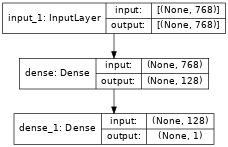

In [20]:
tf.keras.utils.plot_model(tfmodel, show_shapes=True, dpi=48)

In [21]:
loss = tf.keras.losses.BinaryCrossentropy (from_logits=False)
optimizer = keras.optimizers.Adam(lr=1e-3,decay=1e-3/32)
tfmodel.compile(optimizer=optimizer, loss=[loss, loss],metrics=["accuracy"])
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')
fine_history = tfmodel.fit(features_tr, train_y, validation_data=(features_vl,eval_y),
                          epochs=3, callbacks=[checkpoint, earlystopping],batch_size=32,verbose=1)

Epoch 1/3
163/163 [==============================] - 2s 6ms/step - loss: 0.7334 - accuracy: 0.5174 - val_loss: 0.7259 - val_accuracy: 0.4948
Epoch 2/3
163/163 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5647 - val_loss: 0.6652 - val_accuracy: 0.5502
Epoch 3/3
163/163 [==============================] - 0s 3ms/step - loss: 0.6609 - accuracy: 0.6075 - val_loss: 0.6252 - val_accuracy: 0.7010


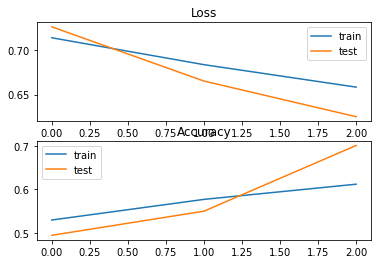

In [22]:
summarize_model(fine_history)

**Evaluation**

In [23]:
#training set
y_pred=tfmodel.predict(features_tr)
y_pred = y_pred.round()
print(classification_report(train_y,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.66      0.69      2583
           1       0.69      0.76      0.72      2614

    accuracy                           0.71      5197
   macro avg       0.71      0.71      0.71      5197
weighted avg       0.71      0.71      0.71      5197



In [24]:
#validation set
y_pred=tfmodel.predict(features_vl)
y_pred = y_pred.round()
print(classification_report(eval_y,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      1415
           1       0.68      0.75      0.71      1384

    accuracy                           0.70      2799
   macro avg       0.70      0.70      0.70      2799
weighted avg       0.70      0.70      0.70      2799



In [25]:
#testing set
y_pred=tfmodel.predict(features_ts)
y_pred = y_pred.round()
print(classification_report(test['Label'],y_pred))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1333
           1       0.68      0.77      0.72      1333

    accuracy                           0.70      2666
   macro avg       0.71      0.70      0.70      2666
weighted avg       0.71      0.70      0.70      2666

